In [243]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2


# Functions


In [248]:
#Helper functions

#plot 4 keypoints 
def _4_plot_crane(keypoints_3d):

    # Swap y and z coordinates for all keypoints
    keypoints_3d[:, [1, 2]] = keypoints_3d[:, [2, 1]]

    # Plot the keypoints and the reconstructed crane
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot keypoints
    colors = ['r', 'g', 'b', 'y']
    labels = ['KeyPoint 1', 'KeyPoint 2', 'KeyPoint 3', 'KeyPoint 4']
    for i, keypoint in enumerate(keypoints_3d):
        ax.scatter(*keypoint, color=colors[i], label=labels[i])

    # Plot lines connecting keypoints
    for i in range(len(keypoints_3d) - 1):
        ax.plot([keypoints_3d[i][0], keypoints_3d[i + 1][0]],
                [keypoints_3d[i][1], keypoints_3d[i + 1][1]],
                [keypoints_3d[i][2], keypoints_3d[i + 1][2]], color='k')
    
    # Set axes labels
    ax.set_xlabel('X')
    ax.set_ylabel('Z')  # Changed ylabel to represent z-axis
    ax.set_zlabel('Y')  # Changed zlabel to represent y-axis
    ax.legend()
    ax.set_title('3D Coordinate System with KeyPoints')
    plt.show()
#---------------------------------------------------------------------------------

#plot 3 keypoints 
def plot_keypoints_and_lines(keypoints_3d):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot keypoints
    colors = ['r', 'g', 'b']
    labels = ['KeyPoint 1', 'KeyPoint 2', 'KeyPoint 3']
    for i, keypoint in enumerate(keypoints_3d):
        ax.scatter(keypoint[0], keypoint[2], keypoint[1], color=colors[i], label=labels[i])

    # Plot lines connecting keypoints
    for i in range(len(keypoints_3d) - 1):
        ax.plot([keypoints_3d[i][0], keypoints_3d[i + 1][0]],
                [keypoints_3d[i][2], keypoints_3d[i + 1][2]],
                [keypoints_3d[i][1], keypoints_3d[i + 1][1]], color='k')

    # Set axes labels
    ax.set_xlabel('X')
    ax.set_ylabel('Z')  # Changed ylabel to represent z-axis
    ax.set_zlabel('Y')  # Changed zlabel to represent y-axis
    ax.legend()
    ax.set_title('3D Keypoints and Lines')
    plt.show()


    
#---------------------------------------------------------------------------------  

# Function to convert normalized keypoints to pixel coordinates
def convert_to_pixel_coordinates(normalized_keypoints, image_size):
    return [(x * image_size, y * image_size) for x, y in normalized_keypoints]

#---------------------------------------------------------------------------------

# Function to calculate 3D positions from stereo image keypoints
def calculate_3d_positions(left_keypoints_pixel, right_keypoints_pixel, focal_length, cx, cy, baseline_distance):
    # Calculate disparity and depth for each keypoint
    disparities = [left[0] - right[0] for left, right in zip(left_keypoints_pixel, right_keypoints_pixel)]
    depths = [focal_length * baseline_distance / disparity for disparity in disparities]
    
    # Calculate the 3D positions (X, Y, Z) for each keypoint
    keypoints_3d = [
        (
            ((x - cx) * depth / focal_length),
            ((y - cy) * depth / focal_length),
            depth
        ) 
        for (x, y), depth in zip(left_keypoints_pixel, depths)
    ]
    
    return keypoints_3d


#---------------------------------------------------------------------------------

def animate_crane_movement(keypoints_series):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Set axes labels and limits
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')
    ax.set_title('3D Crane Movement')

    # Prepare plot elements
    colors = ['r', 'g', 'b']
    labels = ['KeyPoint 1', 'KeyPoint 2', 'KeyPoint 3']
    points = [ax.scatter([], [], [], color=color, label=label) for color, label in zip(colors, labels)]
    lines = [ax.plot([], [], [], 'k')[0] for _ in range(len(keypoints_series[0]) - 1)]
    ax.legend()

    # Initialize plot limits
    x_min, y_min, z_min = np.min(np.array(keypoints_series).reshape(-1, 3), axis=0)
    x_max, y_max, z_max = np.max(np.array(keypoints_series).reshape(-1, 3), axis=0)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(z_min, z_max)
    ax.set_zlim(y_min, y_max)

    # Initialization function
    def init():
        for point in points:
            point._offsets3d = ([], [], [])
        for line in lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return points + lines

    # Animation update function
    def update(frame):
        keypoints_3d = keypoints_series[frame]
        for i, keypoint in enumerate(keypoints_3d):
            points[i]._offsets3d = ([keypoint[0]], [keypoint[2]], [keypoint[1]])
        for i in range(len(keypoints_3d) - 1):
            lines[i].set_data([keypoints_3d[i][0], keypoints_3d[i + 1][0]],
                              [keypoints_3d[i][2], keypoints_3d[i + 1][2]])
            lines[i].set_3d_properties([keypoints_3d[i][1], keypoints_3d[i + 1][1]])
        return points + lines

    # Create animation
    anim = FuncAnimation(fig, update, frames=len(keypoints_series), init_func=init)#, blit=True)

    plt.show()
    
    return anim

#---------------------------------------------------------------------------------

def preprocess_Keypoints_for_animation(data):
    keypoints_series = []
    for i in range(0, len(data), 3):
        keypoints_series.append(np.array(data[i:i+3]))
    return keypoints_series
#---------------------------------------------------------------------------------



# 

# Maching predefind Keypoints

<IPython.core.display.Javascript object>


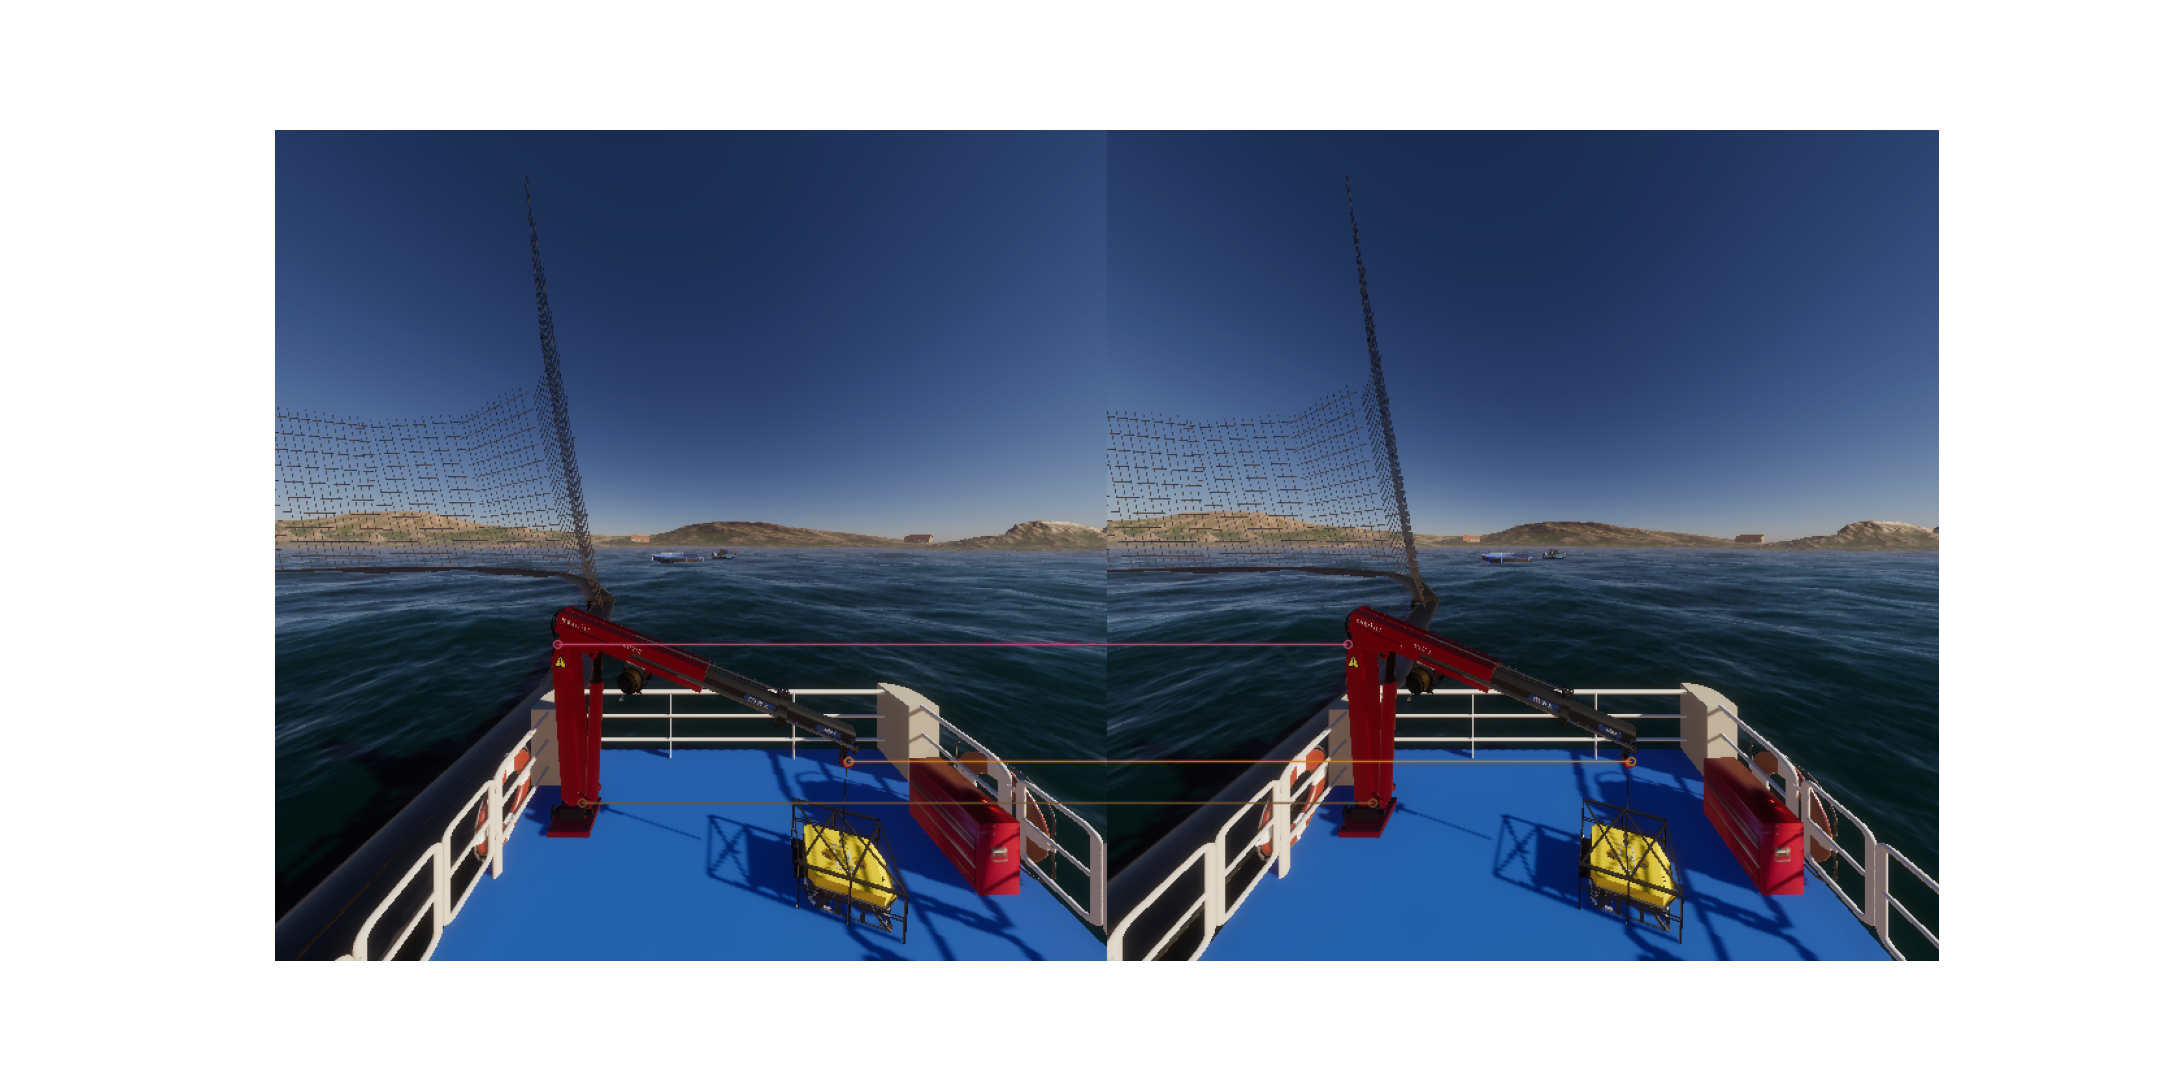

In [245]:
#Match the predefined keypoints from the two images

# Load left and right images
left_image = 'images/imgl16.png'
right_image = 'images/imgr16.png'
left_img = cv2.imread(left_image)
right_img = cv2.imread(right_image)

#---------------------------------------------------------------------------
# Define keypoints in left and right images (normalized coordinates)
left_keypoints_norm = [(0.37,0.19),(0.34,0.38),(0.69,0.24)]
right_keypoints_norm =[(0.32,0.19),(0.29,0.38),(0.63,0.24)] 
#---------------------------------------------------------------------------
# Get image dimensions
left_height, left_width = left_img.shape[:2]
right_height, right_width = right_img.shape[:2]

# Convert normalized keypoints to pixel coordinates
left_keypoints = [(int(x * left_width), int((1 - y) * left_height)) for (x, y) in left_keypoints_norm]
right_keypoints = [(int(x * right_width), int((1 - y) * right_height)) for (x, y) in right_keypoints_norm]

# Convert keypoints to OpenCV KeyPoint objects
left_keypoints_cv2 = [cv2.KeyPoint(x, y, 1) for (x, y) in left_keypoints]
right_keypoints_cv2 = [cv2.KeyPoint(x, y, 1) for (x, y) in right_keypoints]

#---------------------------------------------------------------------------
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
left_keypoints, left_descriptors = sift.compute(left_img, left_keypoints_cv2)
right_keypoints, right_descriptors = sift.compute(right_img, right_keypoints_cv2)

# Initialize feature matcher
bf = cv2.BFMatcher()

# Match features between left and right images
matches = bf.match(left_descriptors, right_descriptors)

# Filter matches to keep only matches corresponding to the defined keypoints
matched_left_keypoints = np.array([left_keypoints[match.queryIdx].pt for match in matches])
matched_right_keypoints = np.array([right_keypoints[match.trainIdx].pt for match in matches])

# Convert matched keypoints to homogeneous coordinates
matched_left_keypoints_homogeneous = np.array([pt + (1,) for pt in matched_left_keypoints]).T
matched_right_keypoints_homogeneous = np.array([pt + (1,) for pt in matched_right_keypoints]).T

#---------------------------------------------------------------------------
# Draw matched keypoints on the images
matched_img = cv2.drawMatches(left_img, left_keypoints, right_img, right_keypoints, matches, None, 
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

matched_img_rgb = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 6))
plt.imshow(matched_img_rgb)
plt.axis('off')
plt.show()


# Reconstructing the 3D Crane

[[-1.466143  -3.868844   4.250089 ]
 [-1.897482  -1.5126     4.139429 ]
 [ 0.3367178 -2.249135   4.81055  ]]


<IPython.core.display.Javascript object>


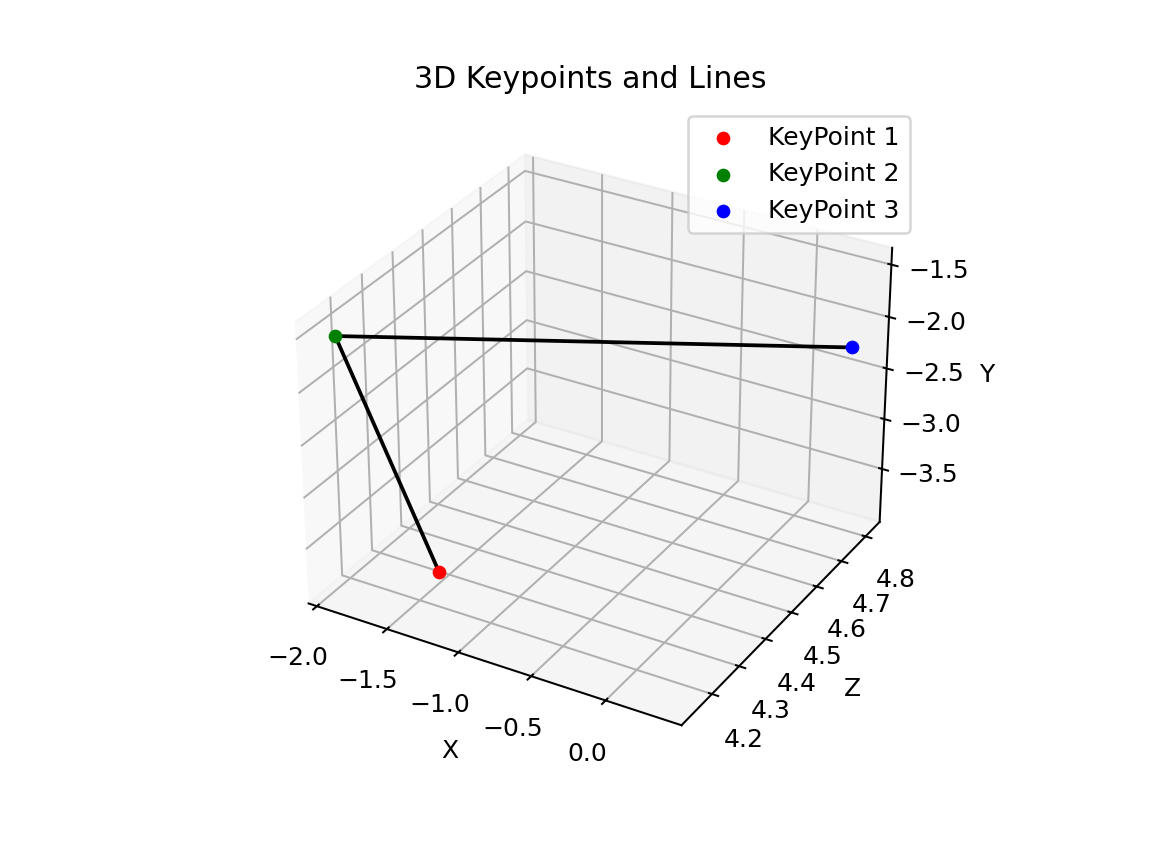

In [246]:
# Actual 3D coordinates to have an idea
actual_keypoint_1 = [-14.66143, -38.68844, 42.50089]
actual_keypoint_2 = [-18.97482, -15.126, 41.39429]
actual_keypoint_3 = [3.367178, -22.49135, 48.1055]



actual_keypoints_3d = np.array([actual_keypoint_1, actual_keypoint_2, actual_keypoint_3])/10

print(actual_keypoints_3d)
plot_keypoints_and_lines(actual_keypoints_3d)

Keypoints in 3D: 
 [[-1.56     -3.72      4.3125  ]
 [-1.92     -1.44      4.3125  ]
 [ 2.4      -3.9       5.390625]]


<IPython.core.display.Javascript object>


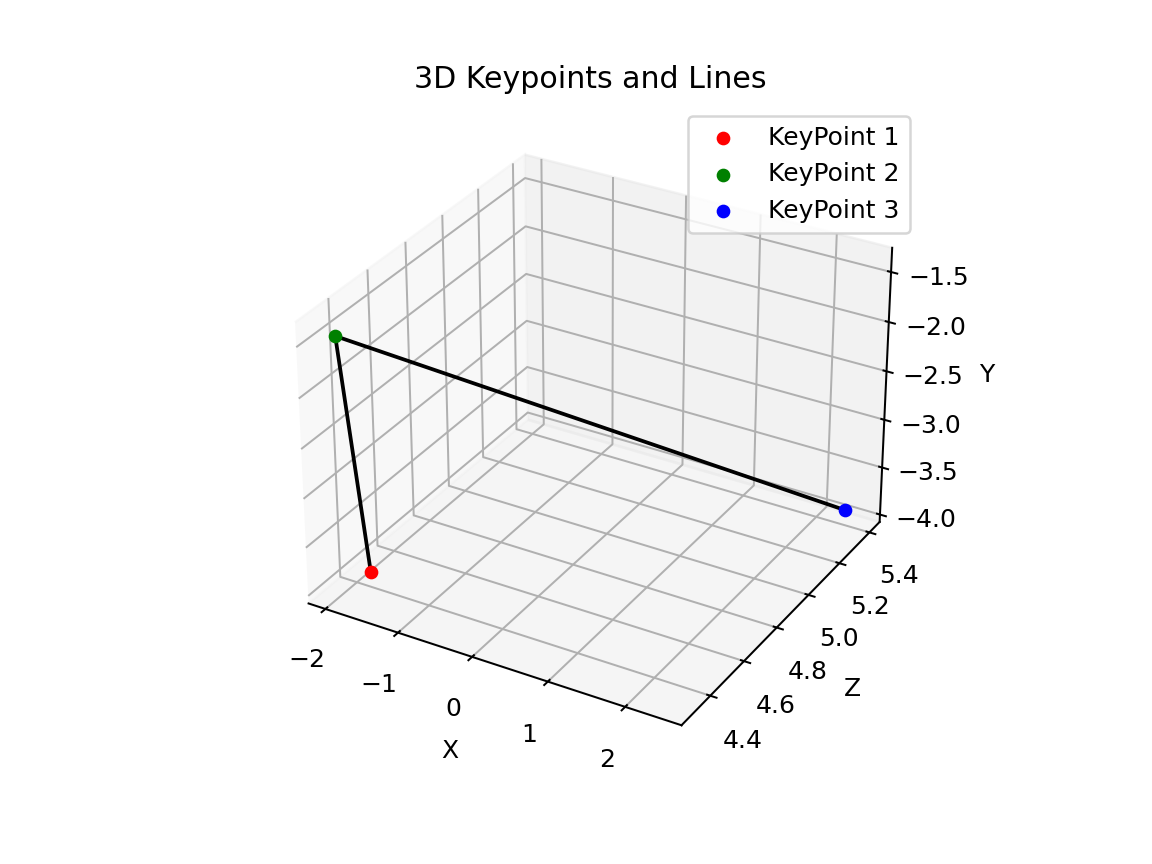

In [247]:
#Triangulation on the keypoints
 
# Define camera parameters
focal_length = 230     # Focal length in mm Focal Length (pixels)= Focal Length (mm)× (Sensor Width (mm) / Image Width (pixels))
cx = 320               # Principal point offset x
cy = 320               # Principal point offset y
baseline_distance = 0.6  # Baseline distance in m
image_size = 640       # Image dimension size (assuming square images)


# Normalized keypoints for left and right images
left_keypoints_norm = [(0.37,0.19),(0.34,0.38),(0.66,0.24)]

right_keypoints_norm =[(0.32,0.19),(0.29,0.38),(0.62,0.24)] 


# Convert normalized keypoints to pixel coordinates
left_keypoints_pixel = convert_to_pixel_coordinates(left_keypoints_norm, image_size)
right_keypoints_pixel = convert_to_pixel_coordinates(right_keypoints_norm, image_size)

# Calculate 3D positions of the keypoints
keypoints_3d = calculate_3d_positions(left_keypoints_pixel, right_keypoints_pixel, focal_length, cx, cy, baseline_distance)
keypoints_3d=np.array(keypoints_3d)

print("Keypoints in 3D: \n",keypoints_3d)
plot_keypoints_and_lines(keypoints_3d)

# 

# 

# Crane animation given 3D pose of keypoints

<IPython.core.display.Javascript object>


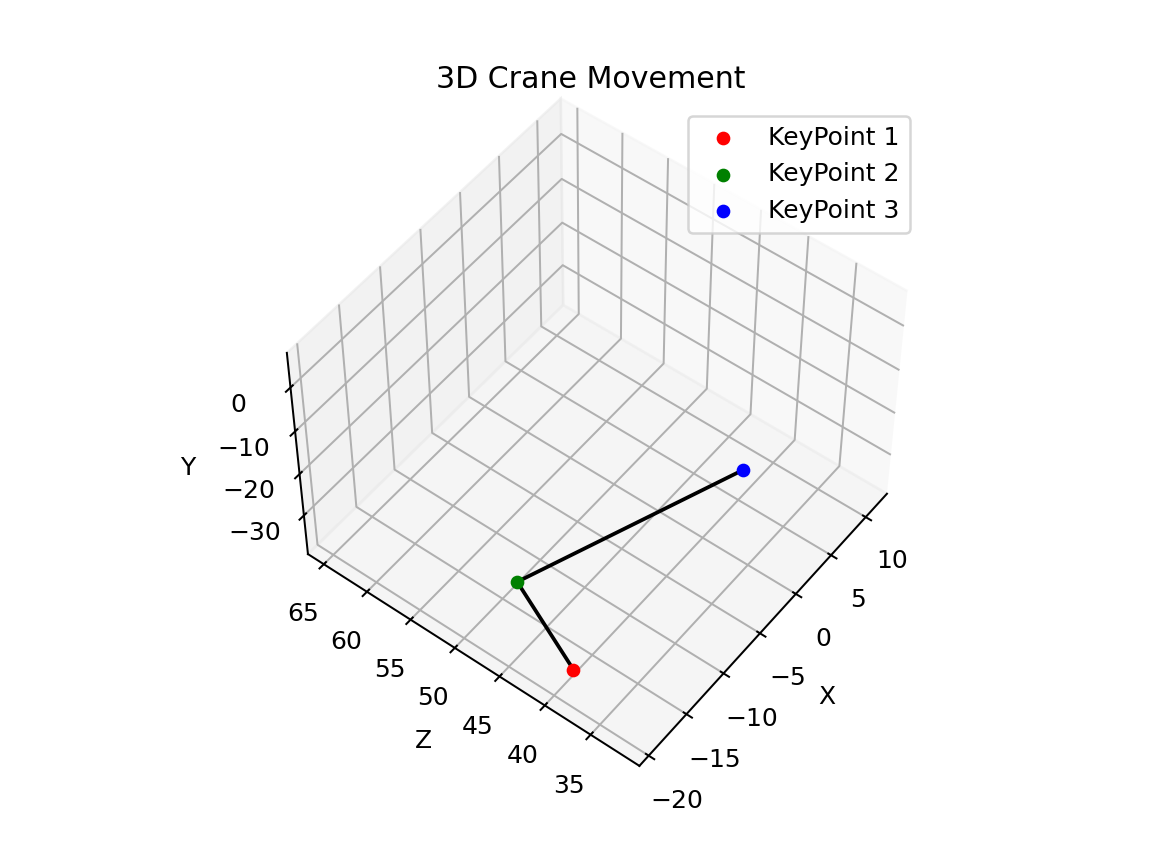

In [241]:
# Example data
data = [
    [-14.60258, -38.658, 42.50035], [-18.97482, -15.126, 41.39429], [3.368208, -22.49127, 48.07296],
    [-14.60258, -38.658, 42.50035], [-18.97482, -15.126, 41.39429], [3.368208, -22.49127, 48.07296],
    [-14.60258, -38.658, 42.50035], [-18.97482, -15.126, 41.39429], [3.368208, -22.49127, 48.07296],
    [-14.60258, -38.658, 42.50035], [-18.97482, -15.126, 41.39429], [3.368208, -22.49127, 48.07296],
    [-14.60258, -38.658, 42.50035], [-18.97482, -15.126, 41.39429], [3.368208, -22.49127, 48.07296],
    [-14.60258, -38.658, 42.50035], [-18.97482, -15.126, 41.39429], [3.368208, -22.49127, 48.07296],
    [-15.08999, -38.658, 41.56204], [-19.59631, -15.126, 41.74331], [3.723462, -22.49127, 41.80119],
    [-15.3056, -38.658, 41.29001], [-19.77486, -15.126, 41.89456], [3.852823, -21.04795, 39.68546],
    [-15.3056, -38.658, 41.29001], [-19.77486, -15.126, 41.89456], [4.46017, -17.55666, 39.57636],
    [-15.3056, -38.658, 41.29001], [-19.77486, -15.126, 41.89456], [4.58298, -14.69491, 39.55239],
    [-15.3056, -38.658, 41.29001], [-19.77486, -15.126, 41.89456], [4.468131, -12.6516, 39.57063],
    [-15.3056, -38.658, 41.29001], [-19.77486, -15.126, 41.89456], [3.920038, -9.356966, 39.66337],
    [-15.3056, -38.658, 41.29001], [-19.77486, -15.126, 41.89456], [2.860167, -5.978584, 39.84538],
    [-15.3056, -38.658, 41.29001], [-19.77486, -15.126, 41.89456], [2.032883, -4.112072, 39.98812],
    [-15.3056, -38.658, 41.29001], [-19.77486, -15.126, 41.89456], [0.5855632, -1.57382, 40.2385],
    [-15.3056, -38.658, 41.29001], [-19.77486, -15.126, 41.89456], [-0.892086, 0.4560661, 40.49462],
    [-15.3056, -38.658, 41.29001], [-19.77486, -15.126, 41.89456], [-0.892086, 0.4560661, 40.49462],
    [-14.60597, -38.658, 42.49065], [-18.98128, -15.126, 41.3968], [3.380303, -22.49127, 48.01304],
    [-14.83861, -38.658, 41.96417], [-19.33089, -15.126, 41.56511], [4.660578, -18.77489, 44.65854],
    [-15.11343, -38.658, 41.52979], [-19.61753, -15.126, 41.75982], [4.851501, -15.3773, 41.45607],
    [-15.51892, -38.658, 41.06529], [-19.92159, -15.126, 42.04323], [3.873382, -11.29789, 37.73315],
    [-15.91222, -38.658, 40.73433], [-20.13594, -15.126, 42.31549], [2.126751, -7.974091, 35.02607],
    [-16.37504, -38.658, 40.44692], [-20.31942, -15.126, 42.63364], [-0.4890919, -4.602833, 32.81225],
    [-16.85576, -38.658, 40.2377], [-20.44983, -15.126, 42.96213], [-3.536487, -1.57382, 31.50663],
    [-17.35123, -38.658, 40.10085], [-20.53114, -15.126, 43.29897], [-6.784189, 1.131039, 31.12613],
    [-17.17071, -38.658, 40.14213], [-20.5073, -15.126, 43.17644], [-4.95846, -1.010065, 30.52632],
    [-16.68275, -38.658, 40.30369], [-20.40916, -15.126, 42.84411], [-0.5551434, -3.166933, 30.48992],
    [-16.21315, -38.658, 40.53681], [-20.26241, -15.126, 42.52259], [3.965175, -6.050367, 31.59405],
    [-15.77336, -38.658, 40.84065], [-20.06735, -15.126, 42.2196], [7.26069, -8.320951, 34.26821],
    [-15.38918, -38.658, 41.1974], [-19.83542, -15.126, 41.95291], [8.81159, -3.717585, 37.85889],
    [-15.06542, -38.658, 41.59665], [-19.57354, -15.126, 41.726], [8.584166, 0.7754135, 41.70717],
    [-14.79108, -38.658, 42.05541], [-19.27046, -15.126, 41.53107], [7.513182, 5.794849, 45.49788],
    [-14.586, -38.658, 42.54905], [-18.94237, -15.126, 41.38206], [7.653172, 6.731873, 49.33361],
    [-14.45633, -38.658, 43.05704], [-18.60295, -15.126, 41.28353], [10.71996, 3.464193, 54.5127],
    [-14.39971, -38.658, 43.58857], [-18.24606, -15.126, 41.23371], [12.42304, -0.7229424, 60.57205],
    [-14.41947, -38.658, 44.11248], [-17.89264, -15.126, 41.23551], [11.51725, -5.880299, 66.11201],


]

# Convert data to keypoints_series format
keypoints_series = preprocess_Keypoints_for_animation(data)

#call the animation function with your data
anim = animate_crane_movement(keypoints_series)
